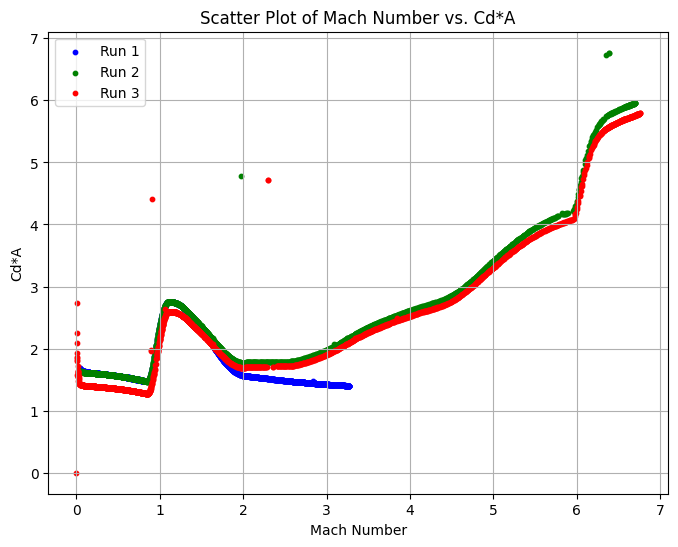

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Read the CSV file
csv_file = "drag_profile.csv"  # Replace with the actual file path

# Read lines from the file
lines = []
with open(csv_file, "r") as f:
    f.readline()
    lines = f.readlines()

# Initialize lists to store data and colors
runs = []
colors = ["blue", "green", "red", "purple", "orange", "pink", "brown", "cyan"]

# Process the lines to extract data and assign colors
current_run = -1
for line in lines:
    line = line.strip()
    if line.startswith("---"):
        runs.append([])
        current_run += 1
        if current_run >= len(colors):
            current_run = 0
        continue

    parts = line.split(",")
    mach_number = float(parts[0])
    cd_a = float(parts[1])
    runs[current_run].append((mach_number, cd_a))

# Create a scatter plot for each run
plt.figure(figsize=(8, 6))
for i, run in enumerate(runs):
    # run is a list of tuples (mach_number, cd_a)
    mach_numbers = [x[0] for x in run]
    cd_as = [x[1] for x in run]
    plt.scatter(
        mach_numbers, cd_as, color=colors[i], label="Run {}".format(i + 1), s=10
    )

plt.title("Scatter Plot of Mach Number vs. Cd*A")
plt.xlabel("Mach Number")
plt.ylabel("Cd*A")
plt.legend()
plt.grid(True)
plt.show()

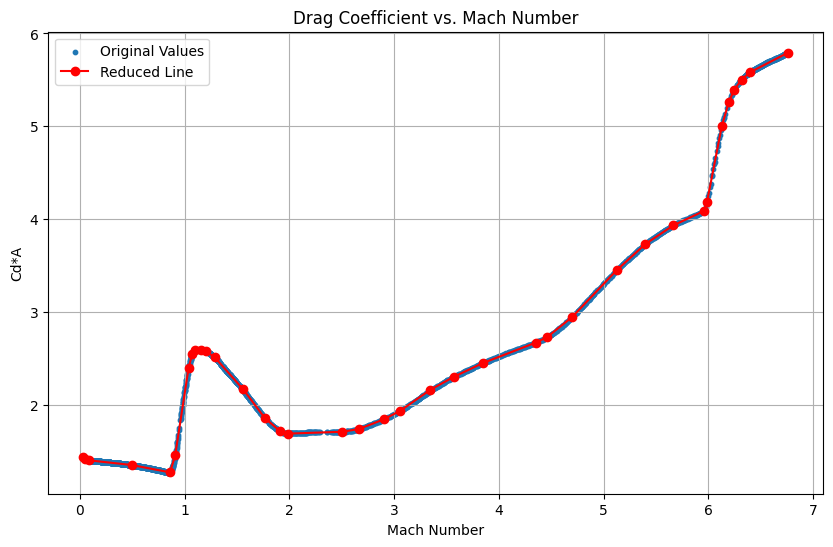

In [16]:
# Takes n most important points and plots them (to make a lookup table)
# TODO: improve to allow for an arbitrary drag profile.
# an idea is maybe to loop over the values and put a new value if the point
# is too far off the line between the previous and current point.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def rdp(points, epsilon):
    dmax = 0
    index = 0
    end = len(points) - 1
    for i in range(1, end):
        d = perpendicular_distance(points[i], points[0], points[end])
        if d > dmax:
            index = i
            dmax = d
    
    if dmax > epsilon:
        results = rdp(points[:index+1], epsilon)[:-1] + rdp(points[index:], epsilon)
    else:
        results = [points[0], points[end]]
    
    return results

def perpendicular_distance(point, start, end):
    line_vector = np.array(end) - np.array(start)
    point_vector = np.array(point) - np.array(start)
    perpendicular_distance = np.linalg.norm(np.cross(line_vector, point_vector)) / np.linalg.norm(line_vector)
    return perpendicular_distance

def main():
    # Read CSV file
    df = pd.read_csv('drag_profile_3.csv')
    
    # Extract data from DataFrame
    mach_numbers = df['Mach number'].values
    drag_coefficients = df['Cd*A'].values
    points = list(zip(mach_numbers, drag_coefficients))
    
    # Set the number of most important points (you can adjust this)
    n_important_points = 25
    
    # Perform data reduction
    reduced_points = rdp(points, epsilon=0.01)
    
    # Choose n_important_points from the reduced points
    step = len(reduced_points) // (n_important_points - 1)
    reduced_points = reduced_points[::step]
    
    # Separate reduced points into Mach numbers and drag coefficients
    reduced_mach_numbers, reduced_drag_coefficients = zip(*reduced_points)
    
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(mach_numbers, drag_coefficients, s=10, label='Original Values')
    plt.plot(reduced_mach_numbers, reduced_drag_coefficients, marker='o', linestyle='-', color='r', label='Reduced Line')
    plt.xlabel('Mach Number')
    plt.ylabel('Cd*A')
    plt.title('Drag Coefficient vs. Mach Number')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()


Segment: [0, 0.85]
1.4157 + -0.0844 * x**1 + -0.0951 * x**2

Segment: [0.85, 1.1]
157.1451 + -495.1551 * x**1 + 517.6693 * x**2 + -177.5173 * x**3

Segment: [1.1, 2]
-4.4169 + 15.5400 * x**1 + -10.8694 * x**2 + 2.3121 * x**3

Segment: [2, 2.5]
1.1359 + 0.4727 * x**1 + -0.0970 * x**2

Segment: [2.5, 3.25]
4.0144 + -2.0210 * x**1 + 0.4388 * x**2

Segment: [3.25, 4.25]
-2.2326 + 1.9329 * x**1 + -0.1858 * x**2

Segment: [4.25, 5]
13.7052 + -5.6143 * x**1 + 0.7075 * x**2

Segment: [5, 6]
-12.0977 + 4.9739 * x**1 + -0.3785 * x**2

Segment: [6, 6.35]
-398.8970 + 127.2061 * x**1 + -10.0028 * x**2

Segment: [6.35, 6.8]
-13.5545 + 5.2814 * x**1 + -0.3580 * x**2



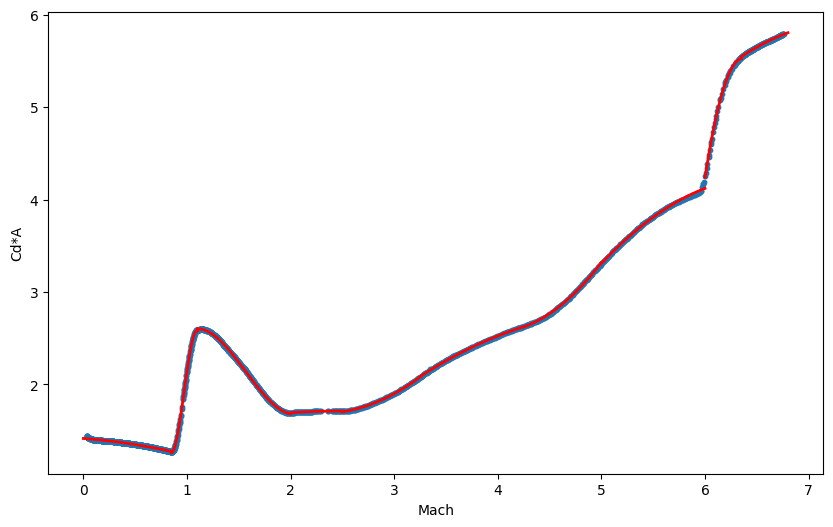

In [17]:
# Fits a number of curves to the drag coefficient data, based on set breakpoints.
# Cannot be used for an arbitrary rocket unless you want to spend some time
# tweaking the breakpoints etc.

# Load and prepare data

import numpy as np
import pandas as pd

# Load the CSV file
data = pd.read_csv('drag_profile_3.csv').sort_values('Mach number')

# Extract axis and series values
mach_values = data['Mach number'].values
cda_values = data['Cd*A'].values

# Define the segments

# Define your estimated breakpoints
breakpoints = [0, 0.85, 1.1, 2, 2.5, 3.25, 4.25, 5, 6, 6.35, 6.8]
degrees = [2, 3, 3, 2, 2, 2, 2, 2, 2, 2]

# Segmented curve fitting

from scipy.optimize import curve_fit

def segment_curve(x, *params):
    return np.polyval(params, x)

# Loop through segments and fit curves
segments = []
for i in range(len(breakpoints) - 1):
    start_idx = np.searchsorted(mach_values, breakpoints[i])
    end_idx = np.searchsorted(mach_values, breakpoints[i + 1])

    segment_x = mach_values[start_idx:end_idx]
    segment_y = cda_values[start_idx:end_idx]

    # Fit a polynomial curve of the desired degree
    degree = degrees[i]
    popt, _ = curve_fit(segment_curve, segment_x, segment_y, p0=np.zeros(degree + 1))
    
    segments.append({
        'start': breakpoints[i],
        'end': breakpoints[i + 1],
        'degree': degree,
        'params': popt
    })
    
for segment in segments:
    segment_equation = f'{segment["params"][-1]:.4f}'
    for i, coef in enumerate(reversed(segment["params"][:-1])):
        segment_equation += f' + {coef:.4f} * x**{i + 1}'
    print(f'Segment: [{segment["start"]}, {segment["end"]}]')
    print(f'{segment_equation}\n')

# Visualize the fit

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(mach_values, cda_values, label='Data', s=10)

for segment in segments:
    segment_x = np.linspace(segment['start'], segment['end'], 100)
    segment_y = segment_curve(segment_x, *segment['params'])
    plt.plot(segment_x, segment_y, label='Segment Curve', color='r', linewidth=2)

plt.xlabel('Mach')
plt.ylabel('Cd*A')
plt.show()
